In [31]:
!pip install pandas matplotlib seaborn numpy ipython scikit-learn nltk transformers datasets
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [32]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# NLP libraries
from nltk.sentiment import SentimentIntensityAnalyzer

# Transformers LLM libraries
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
!pip install datasets
from datasets import Dataset

warnings.filterwarnings('ignore')

Exploratory Data Analysis & PREPROCESSING

In [33]:
# random state for reproduction
random_state = 7

# file path of CSV
file_path = "./all-data.csv"

# load and look at dataframe
raw_df = pd.read_csv(file_path, names=['label', 'text'], encoding='utf-8', encoding_errors='replace')
raw_df.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [34]:
# see if any cells are NA
nan_counts = raw_df.isna().sum()
print("Number of NaN counts in data:\n", nan_counts, "\n")

# count of each label
summary_df = raw_df['label'].value_counts()
print("Count of each label:\n", summary_df, "\n")

# find duplicate rows
duplicate_rows = raw_df.duplicated().sum()
print("Count of duplicated rows:\n", duplicate_rows)

Number of NaN counts in data:
 label    0
text     0
dtype: int64 

Count of each label:
 label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64 

Count of duplicated rows:
 6


In [35]:
# remove duplicate rows
df = raw_df.drop_duplicates()
print("Shape of dataframe before removing duplicate rows:", raw_df.shape)
print("Shape of dataframe after removing duplicate rows:", df.shape)

Shape of dataframe before removing duplicate rows: (4846, 2)
Shape of dataframe after removing duplicate rows: (4840, 2)


Text(0.5, 1.0, 'Count of labels')

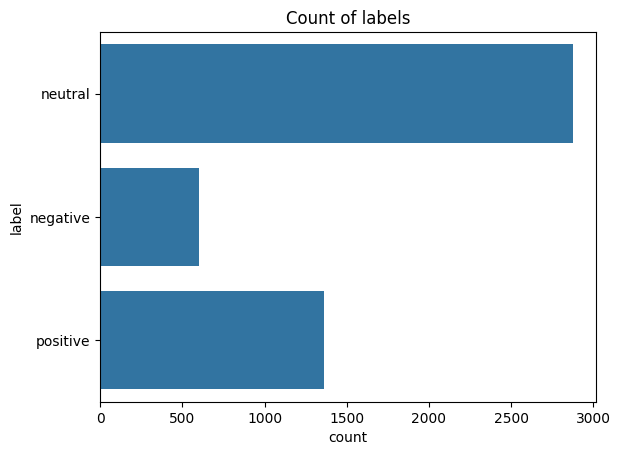

In [36]:
# plot of label counts
sns.countplot(y="label",data=df).set_title("Count of labels")

In [37]:
# average word count for each label
def avg_word_count(df, text_column='text', label_column='label'):
    def word_count(text):
        return len(str(text).split())

    avg_words = df.groupby(label_column)[text_column].apply(lambda x: x.apply(word_count).mean())

    print("Average word count by label:")
    print(avg_words)

    return avg_word_count

avg_word_count(df)

Average word count by label:
label
negative    23.917219
neutral     22.160808
positive    24.692590
Name: text, dtype: float64


<function __main__.avg_word_count(df, text_column='text', label_column='label')>

SPLITTING DATA

In [38]:
# split data
def split_data(df, train_size=0.7, test_size=0.15, eval_size=0.15, random_state=random_state):
    # declare X and y
    X = df['text']
    y = df['label']

    # split data
    train, temp = train_test_split(df, train_size=train_size, random_state=random_state, stratify=df['label'])
    test, eval = train_test_split(temp, train_size=test_size/(test_size + eval_size), random_state=random_state, stratify=temp['label'])

    # declare X and y variables
    X_train = train['text'].reset_index(drop=True)
    y_train = train['label'].reset_index(drop=True)
    X_test = test['text'].reset_index(drop=True)
    y_test = test['label'].reset_index(drop=True)
    X_eval = eval['text'].reset_index(drop=True)
    y_eval = eval['label'].reset_index(drop=True)

    return X_train, X_test, y_train, y_test, X_eval, y_eval

In [39]:
# split data into training, testing, eval
def split_data(df, train_size=0.7, test_size=0.15, eval_size=0.15, random_state=random_state):
    # declare X and y
    X = df['text']
    y = df['label']

    # split data
    train, temp = train_test_split(df, train_size=train_size, random_state=random_state, stratify=df['label'])
    test, eval = train_test_split(temp, train_size=test_size/(test_size + eval_size), random_state=random_state, stratify=temp['label'])

    # declare X and y variables
    X_train = train['text'].reset_index(drop=True)
    y_train = train['label'].reset_index(drop=True)
    X_test = test['text'].reset_index(drop=True)
    y_test = test['label'].reset_index(drop=True)
    X_eval = eval['text'].reset_index(drop=True)
    y_eval = eval['label'].reset_index(drop=True)

    return X_train, X_test, y_train, y_test, X_eval, y_eval

# splits
X_train, X_test, y_train, y_test, X_eval, y_eval = split_data(df)

# check shape of each set
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_eval:", X_eval.shape)
print("Shape of y_eval:", y_eval.shape)

Shape of X_train: (3388,)
Shape of y_train: (3388,)
Shape of X_test: (726,)
Shape of y_test: (726,)
Shape of X_eval: (726,)
Shape of y_eval: (726,)


NAIVE BAYES

In [40]:
# model pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('naive_bayes', (MultinomialNB()))
])

# fit model
nb_pipeline.fit(X_train, y_train)

# get predictions
nb_ypred = nb_pipeline.predict(X_test)

# look at metrics
print("Testing Accuracy:", accuracy_score(y_test, nb_ypred))
print(classification_report(y_test, nb_ypred))

Testing Accuracy: 0.6763085399449036
              precision    recall  f1-score   support

    negative       0.75      0.07      0.12        91
     neutral       0.68      0.98      0.80       431
    positive       0.64      0.31      0.42       204

    accuracy                           0.68       726
   macro avg       0.69      0.45      0.45       726
weighted avg       0.68      0.68      0.61       726



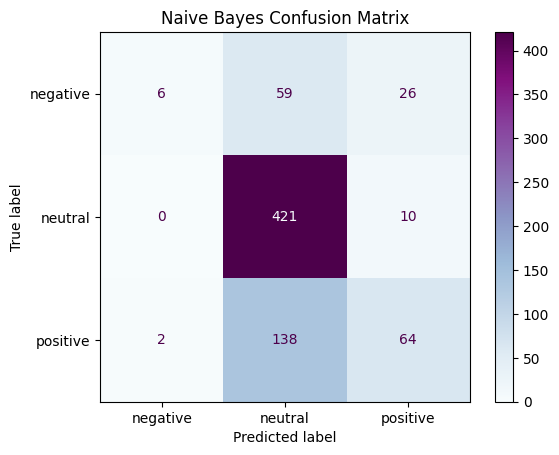

In [41]:
# produce confusion matrix for visualization
conf_matrix = confusion_matrix(y_test, nb_ypred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap="BuPu")
plt.title('Naive Bayes Confusion Matrix')
plt.show()

KNN

In [42]:
# model pipeline
knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', (KNeighborsClassifier()))
])

# fit model
knn_pipeline.fit(X_train, y_train)

# predict
knn_ypred = knn_pipeline.predict(X_test)

# metrics
print("Testing Accuracy:", accuracy_score(y_test, knn_ypred))
print(classification_report(y_test, knn_ypred))

Testing Accuracy: 0.6942148760330579
              precision    recall  f1-score   support

    negative       0.46      0.53      0.49        91
     neutral       0.77      0.84      0.80       431
    positive       0.63      0.47      0.54       204

    accuracy                           0.69       726
   macro avg       0.62      0.61      0.61       726
weighted avg       0.69      0.69      0.69       726



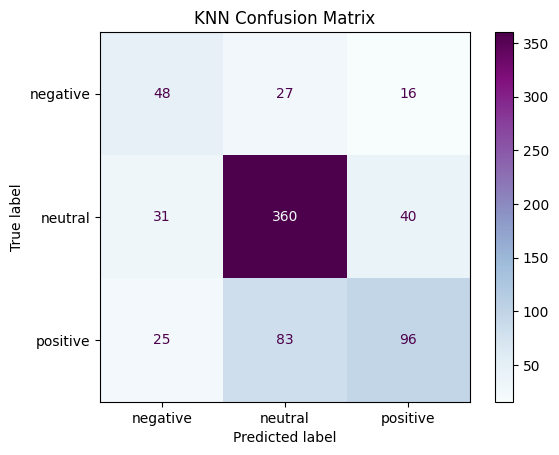

In [43]:
# produce confusion matrix for visualization
conf_matrix = confusion_matrix(y_test, knn_ypred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap="BuPu")
plt.title('KNN Confusion Matrix')
plt.show()

RF

In [44]:
# pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', (RandomForestClassifier(random_state=random_state)))
])
# fit model
rf_pipeline.fit(X_train, y_train)

# predictions
rf_ypred = rf_pipeline.predict(X_test)

# performance metrics
print("Testing Accuracy:", accuracy_score(y_test, rf_ypred))
print(classification_report(y_test, rf_ypred))

Testing Accuracy: 0.7575757575757576
              precision    recall  f1-score   support

    negative       0.84      0.46      0.60        91
     neutral       0.74      0.96      0.84       431
    positive       0.80      0.46      0.58       204

    accuracy                           0.76       726
   macro avg       0.79      0.63      0.67       726
weighted avg       0.77      0.76      0.74       726



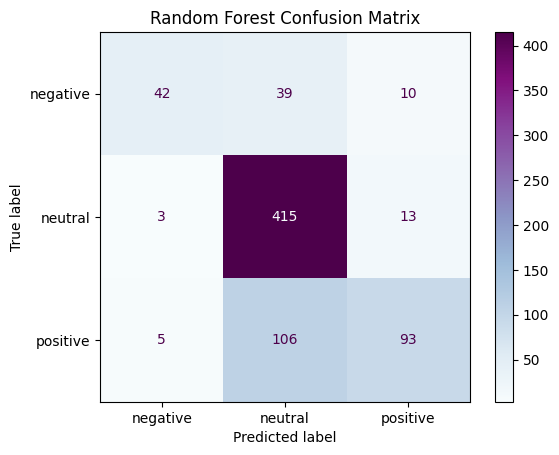

In [45]:
# produce confusion matrix for visualization
conf_matrix = confusion_matrix(y_test, rf_ypred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap="BuPu")
plt.title('Random Forest Confusion Matrix')
plt.show()

NLTK VADER

In [46]:
# get VADER polarity scores
import nltk
nltk.download('vader_lexicon')
def calculate_polarity(text):
    analyzer = SentimentIntensityAnalyzer()
    analyzer_dict = analyzer.polarity_scores(text)

    if analyzer_dict['compound'] >= 0.05:
        return "positive"
    elif analyzer_dict['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"
# apply function to text and produce new column
df['VADER Predicted'] = df['text'].apply(calculate_polarity)
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mahin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,label,text,VADER Predicted
0,neutral,"According to Gran , the company has no plans t...",negative
1,neutral,Technopolis plans to develop in stages an area...,negative
2,negative,The international electronic industry company ...,neutral
3,positive,With the new production plant the company woul...,positive
4,positive,According to the company 's updated strategy f...,positive


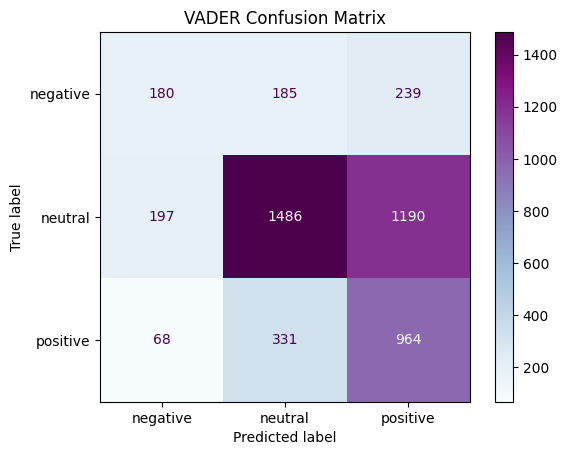

In [47]:
# confusion matrix
conf_matrix = confusion_matrix(df['label'],df['VADER Predicted'],labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap="BuPu")
plt.title('VADER Confusion Matrix')
plt.show()

In [48]:
# performance metrics
class_report = classification_report(df['label'], df['VADER Predicted'], labels=['negative', 'neutral', 'positive'])
print(class_report)

              precision    recall  f1-score   support

    negative       0.40      0.30      0.34       604
     neutral       0.74      0.52      0.61      2873
    positive       0.40      0.71      0.51      1363

    accuracy                           0.54      4840
   macro avg       0.52      0.51      0.49      4840
weighted avg       0.60      0.54      0.55      4840



RoBERTa Model

In [49]:
# initialize roberta model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# built-in model pipeline for sentiment analysis
sen_analysis_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
# get predictions from model
def get_bert_pred(text):
    result = sen_analysis_pipeline(text)[0]
    return result['label'].lower()

# apply function to text and produce new column
df['Roberta Predicted'] = df['text'].apply(get_bert_pred)
df.head()

,label,text,VADER Predicted,Roberta Predicted
0,neutral,"According to Gran , the company has no plans t...",negative,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral
2,negative,The international electronic industry company ...,neutral,negative
3,positive,With the new production plant the company woul...,positive,positive
4,positive,According to the company 's updated strategy f...,positive,neutral


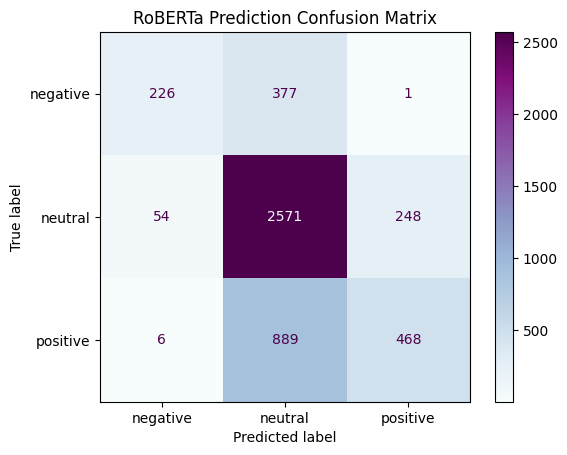

In [51]:
# confusion matrix
conf_matrix = confusion_matrix(df['label'], df['Roberta Predicted'], labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap="BuPu")
plt.title('RoBERTa Prediction Confusion Matrix')
plt.show()

In [52]:
# performance metrics
class_report = classification_report(df['label'], df['Roberta Predicted'], labels=['negative', 'neutral', 'positive'])
print(class_report)

              precision    recall  f1-score   support

    negative       0.79      0.37      0.51       604
     neutral       0.67      0.89      0.77      2873
    positive       0.65      0.34      0.45      1363

    accuracy                           0.67      4840
   macro avg       0.70      0.54      0.57      4840
weighted avg       0.68      0.67      0.64      4840



Training the RoBERTa Model

In [53]:
# split original data into training data and eval data
training_data, val_data = train_test_split(df[['label', 'text']], test_size=0.2, random_state=random_state)
train_data = Dataset.from_pandas(training_data.reset_index(drop=True))
eval_data = Dataset.from_pandas(val_data.reset_index(drop=True))

In [54]:
# tokenize text datasets for model to read
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_data = train_data.map(tokenize_function, batched=True)
eval_data = eval_data.map(tokenize_function, batched=True)

# now that it's tokenized, remove 'text' column
train_data = train_data.remove_columns(['text'])
eval_data = eval_data.remove_columns(['text'])

# conver to integers for model to read
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
train_data = train_data.map(lambda x: {'label': label_mapping[x['label']]})
eval_data = eval_data.map(lambda x: {'label': label_mapping[x['label']]})

# convert to tensors to train model
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
eval_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3872 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 968/968 [00:00<00:00, 20143.31 examples/s]


In [55]:
!pip install transformers[torch] accelerate>=0.26.0


In [56]:
# function for getting metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)

    f1_scores = f1_score(labels, predictions, average=None)
    negative_f1 = f1_scores[0]
    neutral_f1 = f1_scores[1]
    positive_f1 = f1_scores[2]

    return {
        'accuracy': acc,
        'negative_f1': negative_f1,
        'neutral_f1': neutral_f1,
        'positive_f1': positive_f1
    }

# training arguments (fine-tuning)
training_args = TrainingArguments(
    output_dir="logs",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    evaluation_strategy="epoch",
)

# trainer for model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [57]:
# trains and saves model for later
trainer.train()
trainer.model.save_pretrained("trained_model")

 33%|███▎      | 484/1452 [20:26<39:27,  2.45s/it]

{'eval_loss': 0.5130235552787781, 'eval_accuracy': 0.8223140495867769, 'eval_negative_f1': 0.8115942028985508, 'eval_neutral_f1': 0.8612099644128114, 'eval_positive_f1': 0.746268656716418, 'eval_runtime': 56.7591, 'eval_samples_per_second': 17.055, 'eval_steps_per_second': 2.132, 'epoch': 1.0}


 34%|███▍      | 500/1452 [21:03<37:42,  2.38s/it]  

{'loss': 0.6173, 'grad_norm': 3.0824644565582275, 'learning_rate': 6.556473829201102e-05, 'epoch': 1.03}


                                                  
 67%|██████▋   | 968/1452 [42:24<19:26,  2.41s/it]

{'eval_loss': 0.8496133089065552, 'eval_accuracy': 0.8130165289256198, 'eval_negative_f1': 0.7867647058823529, 'eval_neutral_f1': 0.8535714285714285, 'eval_positive_f1': 0.7426470588235294, 'eval_runtime': 54.6155, 'eval_samples_per_second': 17.724, 'eval_steps_per_second': 2.215, 'epoch': 2.0}


 69%|██████▉   | 1000/1452 [43:43<19:24,  2.58s/it] 

{'loss': 0.3908, 'grad_norm': 4.406111717224121, 'learning_rate': 3.1129476584022036e-05, 'epoch': 2.07}


                                                     
100%|██████████| 1452/1452 [1:03:05<00:00,  2.61s/it]


{'eval_loss': 0.7301333546638489, 'eval_accuracy': 0.8336776859504132, 'eval_negative_f1': 0.8, 'eval_neutral_f1': 0.8725065047701648, 'eval_positive_f1': 0.7641325536062378, 'eval_runtime': 54.7485, 'eval_samples_per_second': 17.681, 'eval_steps_per_second': 2.21, 'epoch': 3.0}
{'train_runtime': 3785.1501, 'train_samples_per_second': 3.069, 'train_steps_per_second': 0.384, 'train_loss': 0.4148566138317434, 'epoch': 3.0}


In [58]:
# performance metrics
train_results = trainer.evaluate()

100%|██████████| 121/121 [00:53<00:00,  2.27it/s]


Benchmarking

In [59]:
# get metrics from each model's report
def extract_metrics(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError(f"Mismatch in number of samples: y_true ({len(y_true)}) vs y_pred ({len(y_pred)})")
        
    report = classification_report(y_true, y_pred, output_dict=True)
    
    accuracy = report['accuracy']
    negative_f1 = report.get('negative', {}).get('f1-score', 0)
    neutral_f1 = report.get('neutral', {}).get('f1-score', 0)
    positive_f1 = report.get('positive', {}).get('f1-score', 0)
    
    return accuracy, negative_f1, neutral_f1, positive_f1

# create table of extract reports
def generate_performance_table(df, trainer=None):
    models = [
        ('Naive Bayes', 'nb_ypred', 'y_test'),
        ('KNN', 'knn_ypred', 'y_test'),
        ('Random Forest', 'rf_ypred', 'y_test'),
        ('VADER', "df['VADER Predicted']", "df['label']"),
        ('RoBERTa', "df['Roberta Predicted']", "df['label']")
    ]
    
    # adds in trained model
    if trainer is not None:
        models.append(('Fine-Tuned Model', None, None))
    
    results = []
    
    # iterate over all models
    for model_name, pred_var, true_var in models:
        try:
            if model_name == 'Fine-Tuned Model' and trainer is not None:
                # Evaluate the fine-tuned model
                eval_results = trainer.evaluate()
                accuracy = eval_results['eval_accuracy']
                neg_f1 = eval_results['eval_negative_f1']
                neu_f1 = eval_results['eval_neutral_f1']
                pos_f1 = eval_results['eval_positive_f1']
            else:
                y_true = eval(true_var)
                y_pred = eval(pred_var) if pred_var.startswith('df[') else globals()[pred_var]
                accuracy, neg_f1, neu_f1, pos_f1 = extract_metrics(y_true, y_pred)
            
            results.append([model_name, accuracy, neg_f1, neu_f1, pos_f1])
            
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            results.append([model_name, None, None, None, None])
    
    # get results for table
    result_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Negative F1 Score', 'Neutral F1 Score', 'Positive F1 Score'])
    result_df.set_index('Model', inplace=True)
    return result_df

# displays table
performance_table = generate_performance_table(df, trainer)
display(performance_table.style.format({col: '{:.2f}' for col in performance_table.columns}))

100%|██████████| 121/121 [00:53<00:00,  2.28it/s]


,Accuracy,Negative F1 Score,Neutral F1 Score,Positive F1 Score
Model,,,,
Naive Bayes,0.68,0.12,0.80,0.42
KNN,0.69,0.49,0.80,0.54
Random Forest,0.76,0.60,0.84,0.58
VADER,0.54,0.34,0.61,0.51
RoBERTa,0.67,0.51,0.77,0.45
Fine-Tuned Model,0.83,0.80,0.87,0.76
